In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 12.3 MB/s 
     |████████████████████████████████| 49 kB 3.6 MB/s 
  Created wheel for pandoc: filename=pandoc-2.3-py3-none-any.whl size=33284 sha256=16cd9a11577741326b255de4729f23a60d75452accca5955fcd098f801d3b2cd
  Stored in directory: /root/.cache/pip/wheels/90/3a/a8/3237a93e3a6261bd24edabf3277ca59f64c1710b3d8c7c72a0
Successfully built pandoc


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Library Imports

In [3]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# import pandoc

# Reading Data

##Reading train and test data

# Train

In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/train.csv")
df_train["date"] = pd.to_datetime(df_train['date'], format='%Y-%m-%d') # formatting the date
df_train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [6]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
for i in df_train.columns:
  print('{}---------------{}'.format(i,df_train[i].nunique()))

id---------------3000888
date---------------1684
store_nbr---------------54
family---------------33
sales---------------379610
onpromotion---------------362


# Test

In [8]:
df_test = pd.read_csv("/content/drive/MyDrive/ML Project /Time Series Analysis/Data/test.csv")
df_test["date"] = pd.to_datetime(df_test['date'], format='%Y-%m-%d') # formatting the date

In [9]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [11]:
df_test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [12]:
for i in df_test.columns:
  print('{}---------------{}'.format(i,df_test[i].nunique()))

id---------------28512
date---------------16
store_nbr---------------54
family---------------33
onpromotion---------------212


In [13]:
df_final_arma = pd.DataFrame(columns=['id','date','store_nbr','family','onpromotion','pred'])

## Reading store data

In [14]:
df_stores = pd.read_csv('/content/drive/MyDrive/ML Project /Time Series Analysis/Data/stores.csv')

In [ ]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
df_stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [ ]:
for i in df_stores.columns:
  print('{}---------------{}'.format(i,df_stores[i].nunique()))

store_nbr---------------54
city---------------22
state---------------16
type---------------5
cluster---------------17


# Creating Combination of store number, cluster & product family

In [ ]:
#Fetching list of unique products and store numbers
family_list = df_train['family'].unique().tolist()
store_list = df_train['store_nbr'].unique().tolist()

In [ ]:
comb_store_family = list(itertools.product(store_list, family_list))
len(comb_store_family)

1782

# Merging of store numbers with their respective cluster

In [ ]:
df_merge = pd.merge(df_train, df_stores[['store_nbr','cluster']], how='left', on='store_nbr')

In [ ]:
df_merge.head()

,id,date,store_nbr,family,sales,onpromotion,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,13
1,1,2013-01-01,1,BABY CARE,0.0,0,13
2,2,2013-01-01,1,BEAUTY,0.0,0,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,13
4,4,2013-01-01,1,BOOKS,0.0,0,13


#Checking lags using PACF

In [ ]:
family_list

['AUTOMOTIVE',
 'BABY CARE',
 'BEAUTY',
 'BEVERAGES',
 'BOOKS',
 'BREAD/BAKERY',
 'CELEBRATION',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'HARDWARE',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME APPLIANCES',
 'HOME CARE',
 'LADIESWEAR',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MAGAZINES',
 'MEATS',
 'PERSONAL CARE',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'POULTRY',
 'PREPARED FOODS',
 'PRODUCE',
 'SCHOOL AND OFFICE SUPPLIES',
 'SEAFOOD']

In [ ]:
cluster_mapping = df_merge[['store_nbr',"cluster","family"]].groupby(['store_nbr',"cluster","family"]).count().reset_index()

In [ ]:
cluster_mapping

,store_nbr,cluster,family
0,1,13,AUTOMOTIVE
1,1,13,BABY CARE
2,1,13,BEAUTY
3,1,13,BEVERAGES
4,1,13,BOOKS
...,...,...,...
1777,54,3,POULTRY
1778,54,3,PREPARED FOODS
1779,54,3,PRODUCE
1780,54,3,SCHOOL AND OFFICE SUPPLIES


In [ ]:
cluster_mapping[cluster_mapping["cluster"]==1]

,store_nbr,cluster,family
759,24,1,AUTOMOTIVE
760,24,1,BABY CARE
761,24,1,BEAUTY
762,24,1,BEVERAGES
763,24,1,BOOKS
...,...,...,...
886,27,1,POULTRY
887,27,1,PREPARED FOODS
888,27,1,PRODUCE
889,27,1,SCHOOL AND OFFICE SUPPLIES


P-value:  2.030771497359445e-06


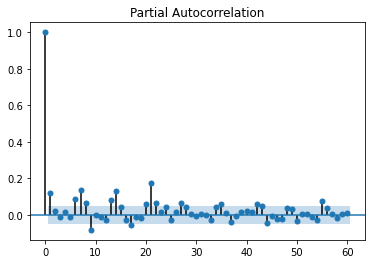

In [ ]:
#providing custom inputs
df_temp = df_merge[(df_merge['store_nbr']==51)&(df_merge['family']=="AUTOMOTIVE")&(df_merge['cluster']==17)]
df_stationarityTest = adfuller(df_temp['sales'].values, autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(df_temp['sales'].values, lags=60) #change "lags" according to convienience

P-value:  2.030771497359445e-06


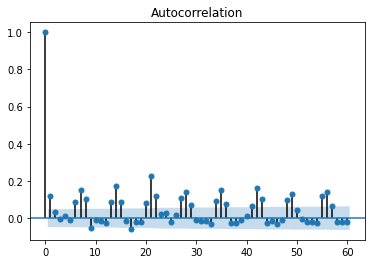

In [ ]:
#providing custom inputs
df_temp = df_merge[(df_merge['store_nbr']==51)&(df_merge['family']=="AUTOMOTIVE")&(df_merge['cluster']==17)]
df_stationarityTest = adfuller(df_temp['sales'].values, autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_acf(df_temp['sales'].values, lags=60) #change "lags" according to convienience

In [ ]:
#fetching every row in list
list_df = cluster_mapping.values.tolist()

In [ ]:
#average lags per cluster
cluster_lag_map = {1:14,2:18,3:8,4:13,5:14,6:7,7:10,8:10,9:15,10:9,11:7,12:14,13:21,14:8,15:9,16:8,17:7}

# ARMA

In [ ]:
Stores = list(df_merge['store_nbr'].unique())
Clu = list(df_merge['cluster'].unique())
Fam = list(df_merge['family'].unique())

In [ ]:
import time

#providing custom inputs
for j in Fam[20:len(Fam)]:
  df_temp = df_merge[(df_merge['family']==j)&(df_merge['cluster']==1)]
  df_stationarityTest = adfuller(df_temp['sales'].values)
  print("P-value: ", df_stationarityTest[1])
  acf = plot_acf(df_temp['sales'].values, lags=60) #change "lags" according to convienience
time.sleep(10)

In [ ]:
cluster_lag_map_MA = {1:20,2:12,3:7,4:19,5:8,6:6,7:13,8:20,9:14,10:6,11:21,12:8,13:29,14:28,15:5,16:7,17:8}

In [ ]:
for i in list_df:
  print("NEW ITERATION")
  print(i)
  df_temp = df_merge[(df_merge['store_nbr']==i[0])&(df_merge['family']==i[2])].reset_index(drop = True)
  df_temp["sales"] = np.log(df_temp["sales"]) #logarithmic normalization
  df_temp = df_temp.fillna(0) #filling null values
  df_temp = df_temp.replace([np.inf, -np.inf], 0) #filling values when log(0) takes place which cannot be computed
  df_test_temp =  df_test[(df_test['store_nbr']==i[0])&(df_test['family']==i[2])].reset_index(drop = True)
  if len(df_test_temp)>0:
    arma_model = ARMA(df_temp["sales"], order=(cluster_lag_map[i[1]],cluster_lag_map_MA[i[1]])).fit() #fitting the model
    df_test_temp["pred"] = np.exp(arma_model.predict(start=len(df_temp), end=(len(df_temp)+len(df_test_temp)-1), dynamic=False).reset_index(drop=True).values)
    df_final_arma = pd.concat([df_final_arma, df_test_temp])

## Joining test set with predict to submission file based on id column

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Store_Sales/sample_submission.csv")
# df_sample["sales"] = df_final["pred"].values
df_sample_merge = pd.merge(df_sample["id"], df_final_arma[['id','sales']], how='left', on='id')

## Saving the submission file to a drive

In [ ]:
df_final_arma.to_csv('/content/drive/MyDrive/Store_Sales/ARMA_predictions.csv')